# One Arizona 

|   About the script    |                                         |
| ----------- | --------------------------------------- |
| Last update | Dec 4 2019                            |
| Experiment  | One Arizona                                 |
| Dataset     | csv file convert from full_results_file.dta using STATA |


| Covariates Used   |      |
| ----------- | --------------------------------------- |
| Vote History| general, middle, party elections (2000 to 2014) |
| Vote Propensity | predicted by logit regression using voting history |

In [2]:
# load libraries

# data cleaning and reshape
import pandas as pd
import numpy as np

# caculate standard error
from scipy.stats import sem

# regression
import statsmodels.api as sm
# regression use formualar
import statsmodels.formula.api as smf
# regression with clustered standard error
import econtools.metrics as mt

# plot display
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

# supress warning inline
import warnings
warnings.filterwarnings('ignore')

# display and export regression table
from stargazer.stargazer import Stargazer
# display latex and html table
from IPython.display import Latex
from IPython.display import HTML

In [14]:
# set random seed to ensure the following code and result is replicable
np.random.seed(2019)

In [62]:
df=pd.read_csv('../../Machine Learing HTE/1_data/az_one/az_one_full.csv',encoding='latin1')

In [63]:
df.shape

(250629, 83)

In [64]:
df.columns

Index(['uniqueid', 'vanid', 'dwid', 'address', 'city', 'state', 'zip',
       'lastname', 'firstname', 'middlename', 'suffix', 'phonenumber',
       'countyname', 'precinctname', 'regdate', 'newreg', 'pevlflag', 'hh_id',
       'hh_size', 'treat_ind', 'ExpGroup', 'missing', 'vf_g2016', 'vf_g2014',
       'vf_g2012', 'vf_g2010', 'vf_g2008', 'vf_g2006', 'vf_g2004', 'vf_g2002',
       'vf_g2000', 'vf_p2014', 'vf_p2014_party', 'vf_p2012', 'vf_p2012_party',
       'vf_p2010', 'vf_p2010_party', 'vf_p2008', 'vf_p2008_party', 'vf_p2006',
       'vf_p2006_party', 'vf_p2004', 'vf_p2004_party', 'vf_p2002',
       'vf_p2002_party', 'vf_p2000', 'vf_p2000_party', 'vf_m2015', 'vf_m2013',
       'vf_m2012', 'vf_m2011', 'vf_m2010', 'vf_m2009', 'vf_m2007', 'vf_pp2016',
       'vf_pp2016_party', 'vf_pp2012', 'vf_pp2008', 'vf_pp2008_party',
       'vf_pp2004', 'vf_pp2000', 'univ', 'message_time1GOTV',
       'message_text1GOTV', 'group_implementedGOTV', 'message_time1exp',
       'message_text1exp', 'grou

## Calculate probability of assignment under cluster and block assignment

According to the assignment file '1_hustle_randomize.do', the researcher blocked three variables: `hh_size`, `newreg`, `pevlflag`.

In [65]:
# create block id
df['block'] = df[['hh_size', 'newreg', 'pevlflag']].\
replace([np.nan], ['N']).\
reset_index(drop=True).groupby(['hh_size', 'newreg', 'pevlflag']).ngroup()

In [66]:
# calculate probability of being assigned to text massaging
df[['treat_any_txt','hh_id','block']].\
    drop_duplicates().groupby(by = ['block']).\
    treat_any_txt.agg([('prob','mean')]).\
merge( df[['treat_any_txt','hh_id','block']].groupby('block').treat_any_txt.agg([('n', 'size')]),
      left_index=True, 
      right_index=True).reset_index()

,block,prob,n
0,0,0.818835,48707
1,1,0.819374,77010
2,2,0.818395,27257
3,3,0.819830,51407
4,4,0.819709,8352
5,5,0.818713,14234
6,6,0.820676,5211
7,7,0.821026,10497
8,8,0.823678,1176
9,9,0.810562,1920


In [67]:
# merge the probability to dataset
df['prob'] = df[['block']].\
merge( 
    df[['treat_any_txt','hh_id','block']].\
    drop_duplicates().groupby(by = ['block']).\
    treat_any_txt.agg([('prob','mean')]).reset_index(),
                   how='left',
                   on='block').prob

In [68]:
# the inverse probability weight (ipw) for each individual
df['ipw'] = 1/df['prob']

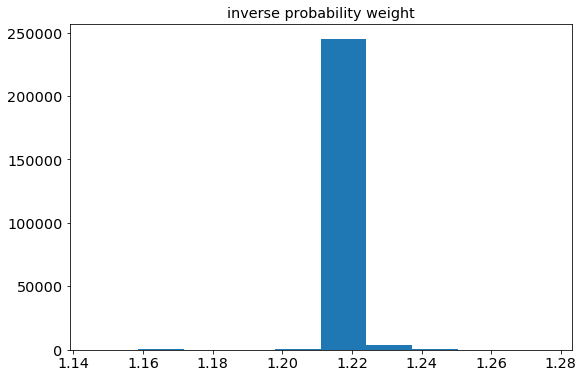

In [69]:
# histogram od inverse probability weight
plt.figure(figsize=(9,6))
ax = plt.hist(df.ipw)
plt.title('inverse probability weight')
plt.show(ax)

## Intervention Description

One Arizona identified 250,629 voters it was prepared to text as part of the experiment who had mobile phone numbers.  

In [70]:
# Dimension of Data
df.shape

(250629, 86)

In [6]:
def p_latex(x, cap):
    latex_string = '\\begin{table}[ht]\\centering\n\\caption{' + cap +'}\n'  
    latex_string = latex_string+x.to_latex().\
    replace('\\toprule','\\hline\\hline\\\\[-1em]').\
    replace('\\bottomrule', '\\hline \\hline') +'\\end{table}'
    return Latex(latex_string)

In [72]:
# description of assignment and compliance
def f(x):
    d = {}
    d['Group Size'] = x['got_any_text'].count()
    d['Compliance Rate'] = ((x['treat_any_txt']==x['got_any_text']).sum())/x['got_any_text'].count()
    d['Proportion to Subject Pool'] =  x['got_any_text'].count()/df.shape[0] 

    return pd.Series(d, index=[ 'Group Size',
                               'Compliance Rate',
                               'Proportion to Subject Pool'])

**Document report**:

One Arizona was randomly assigned to text 205,358 a Get Out The Vote message using Hustle. Of these target voters, 200,442 were successfully sent a message as part of the program (some numbers were invalid). Thus, the “compliance rate” is 20,0442 / 205,358 = 97.6%.

In [73]:
df[['treat_any_txt',
    'got_any_text',
   'vf_g2016']].groupby('treat_any_txt').apply(f).rename_axis("Assignment").rename(index={0: 'control',
                                                                                         1: 'treatment'})

,Group Size,Compliance Rate,Proportion to Subject Pool
Assignment,,,
control,45271.0,1.000000,0.18063
treatment,205358.0,0.976061,0.81937


In [74]:
to_p = df[['treat_any_txt',
    'got_any_text',
   'vf_g2016']].groupby('treat_any_txt').apply(f).rename_axis("Assignment").rename(index={0: 'control',
                                                                                         1: 'treatment'})

In [75]:
p_latex(to_p, 'Non-compliance in One Arizona')

<IPython.core.display.Latex object>

In [76]:
df.vf_g2016.isna().sum()

23631

In [77]:
# outcome missing by assignemnt and compliance
def f(x):
    d = {}
    d['Assignment Group'] =  x['got_any_text'].count()
    d['Outcome Missing'] =  (x['vf_g2016'].isna()).sum()
    d['Outcome Missing Complaints'] = (pd.isnull(x['vf_g2016']) & (x['treat_any_txt']==x['got_any_text'])).sum()
    d['Outcome Available Complaints'] = ((pd.isnull(x['vf_g2016'])==False) & (x['treat_any_txt']==x['got_any_text'])).sum()

    return pd.Series(d, index=[ 'Assignment Group',
                               'Outcome Missing',
                               'Outcome Missing Complaints',
                               'Outcome Available Complaints'])

In [78]:
df[['treat_any_txt',
    'got_any_text',
   'vf_g2016']].groupby('treat_any_txt').apply(f).rename_axis("Assignment").rename(index={0: 'control',
                                                                                         1: 'treatment'})

,Assignment Group,Outcome Missing,Outcome Missing Complaints,Outcome Available Complaints
Assignment,,,,
control,45271,4158,4158,41113
treatment,205358,19473,19031,181411


Turnout rate by Treatment Assignment (drop subject without turnout record)

In [79]:
# Turnout Comparison by Assignment
# Subjects without turnout record are dropped
to_p = df[df.vf_g2016.isna()==False][['treat_any_txt','got_any_text','vf_g2016']]. \
groupby('treat_any_txt')["vf_g2016"].\
agg({'Turnout Rate':'mean',
    'Assignment Group': 'count'}).\
rename_axis("Assignment").\
rename(index={0: 'control',1: 'treatment'})

In [80]:
p_latex(to_p, 'Turnout Comparison in One Arizona')

<IPython.core.display.Latex object>

In [81]:
df[df.vf_g2016.isna()==False].vf_g2016.mean()

0.6431554463034916

## Vote Propensity: The probability of voting based on vote history

In [82]:
pro_data = pd.concat([df.treat_any_txt,
                      # outcome
                      df.vf_g2016, 
                      # vote history
                      df.loc[:,'vf_g2014':'vf_pp2000']], axis=1).dropna()


In [83]:
pro_data.shape

(226998, 40)

In [84]:
y = pro_data[pro_data.treat_any_txt==0].vf_g2016
X = pro_data[pro_data.treat_any_txt==0].loc[:,'vf_g2014':'vf_pp2000']

In [85]:
y.shape

(41113,)

In [86]:
# Create interaction terms between vote histories
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(interaction_only=True,include_bias = False)
X_in = poly.fit_transform(X)

In [87]:
X_in.shape

(41113, 741)

In [88]:
from sklearn.linear_model import LogisticRegression
# Note: logistic regression in sklearn is preset to be a regularization model with C=100).
# C is the tuning parameter like alpha in Reidge and Lasso regression Reguilization
logreg = LogisticRegression(C=1e90).fit(X_in, y)

In [89]:
all_in=poly.fit_transform(pro_data.loc[:,'vf_g2014':'vf_pp2000'])

In [90]:
vp = logreg.predict_proba(all_in)

In [91]:
vp_df = pd.DataFrame(data={'vote_propensity': vp[:,1]}, index = pro_data.index)
df = pd.merge(df, vp_df,left_index=True,
    right_index=True,how='left')

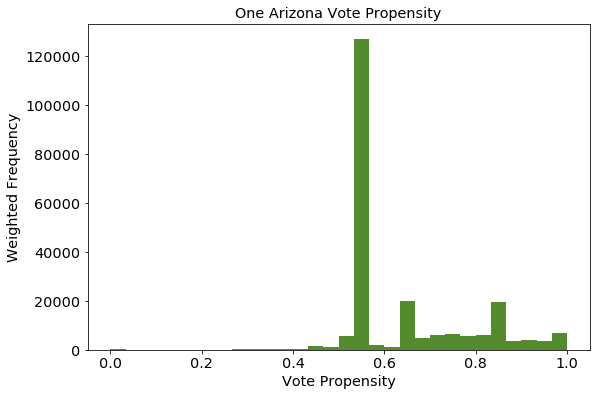

In [92]:

import matplotlib.pylab as pylab
params = {
        'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

plt.figure(figsize=(9,6))
ax = plt.hist(df.vote_propensity, 
         30,color='#558b2f')
plt.xlabel("Vote Propensity")
plt.ylabel("Weighted Frequency")
plt.title("One Arizona Vote Propensity") # You can comment this line out if you don't need title
plt.show(ax)

In [93]:
df.to_csv('../../Machine Learing HTE/1_data/az_one/az_one_add.csv', index=False)

In [94]:
# Cut vote propensity score into 10 bins
df['vp_10']=pd.cut(df.vote_propensity, np.arange(0,1.1,0.1))

In [95]:
def f(x):
    d = {}
    d['weighted size'] = x['ipw'].sum()
    d['size'] = x['ipw'].count()
    d['turnout'] = x['vf_g2016'].mean()
    d['proportion to available outcome'] = x['ipw'].count()/df[df.vote_propensity.isna()==False].shape[0]
    
    return pd.Series(d,
                    index =['weighted size', 'size','turnout','proportion to available outcome'])

In [96]:
df_vp =df[['vp_10','vf_g2016','ipw']]. \
groupby(['vp_10']). \
apply(f).reset_index()

In [97]:
df_vp

,vp_10,weighted size,size,turnout,proportion to available outcome
0,"(0.0, 0.1]",633.695985,519.0,0.670520,0.002286
1,"(0.1, 0.2]",302.758849,248.0,0.612903,0.001093
2,"(0.2, 0.3]",435.804926,357.0,0.507003,0.001573
3,"(0.3, 0.4]",640.865471,525.0,0.584762,0.002313
4,"(0.4, 0.5]",3257.491164,2668.0,0.467016,0.011753
5,"(0.5, 0.6]",164665.287166,134914.0,0.554968,0.594340
6,"(0.6, 0.7]",31784.586947,26035.0,0.664183,0.114693
7,"(0.7, 0.8]",22216.698270,18198.0,0.760853,0.080168
8,"(0.8, 0.9]",35506.324971,29089.0,0.846196,0.128147
9,"(0.9, 1.0]",17635.078003,14445.0,0.909311,0.063635


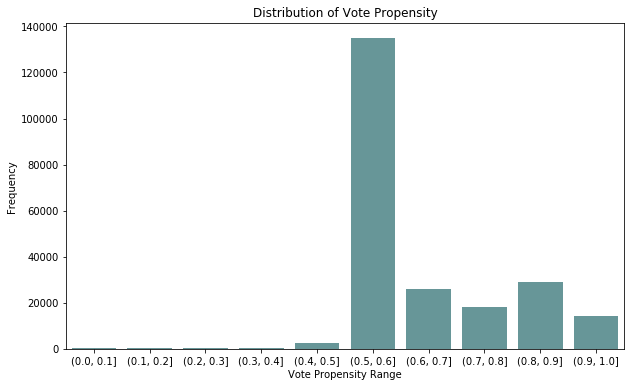

In [31]:
plt.figure(figsize=(10,6))
ax = sns.barplot(x="vp_10", y="size", data=df_vp, color='cadetblue',orient='v')
plt.xlabel("Vote Propensity Range")
plt.ylabel("Frequency")
plt.title("Distribution of Vote Propensity") # You can comment this line out if you don't need title
plt.show(ax)

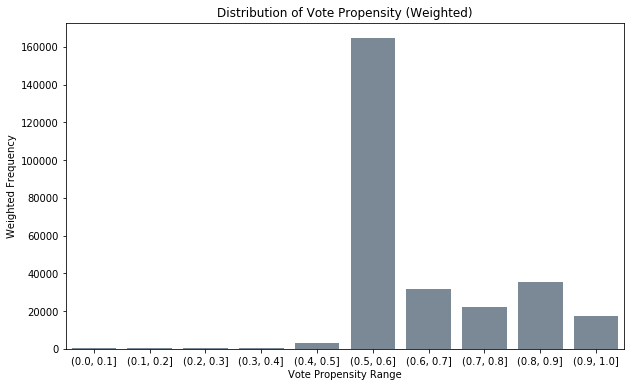

In [32]:
plt.figure(figsize=(10,6))
ax = sns.barplot(x="vp_10", y="weighted size", data=df_vp, color='lightslategrey',orient='v')
plt.xlabel("Vote Propensity Range")
plt.ylabel("Weighted Frequency")
plt.title("Distribution of Vote Propensity (Weighted)") # You can comment this line out if you don't need title
plt.show(ax)

In [98]:
def get_bins_table():
    pd.options.display.float_format = '{:.3%}'.format
    a = df[['vp_10','vf_g2016','treat_any_txt']].\
    groupby(['vp_10',"treat_any_txt"]). \
    vf_g2016.agg([('Size','count'),
              ('Turnout',np.mean),
                ('Proportion', lambda x: x.count()/df[df.vote_propensity.isna()==False].shape[0])]).reset_index()
    
    b = df[['vp_10','vf_g2016','treat_any_txt']].\
    groupby(['vp_10',"treat_any_txt"]). \
    vf_g2016.agg([('Size','count'),
              ('Turnout',np.mean)]).reset_index().groupby('vp_10').Turnout.agg([('Effect','diff')])
    
    r = pd.concat([a,b], axis=1)
    r.rename(columns={'vp_10': 'Vote Propensity Range'}, inplace = True)
    r.Effect.fillna(" ", inplace=True)
    r.treat_any_txt.replace([0,1],['Control', 'Treatment'], inplace=True)
    return r
  

In [99]:
get_bins_table()

,Vote Propensity Range,treat_any_txt,Size,Turnout,Proportion,Effect
0,"(0.0, 0.1]",Control,61,1.639%,0.027%,
1,"(0.0, 0.1]",Treatment,458,75.764%,0.202%,74.125%
2,"(0.1, 0.2]",Control,27,18.519%,0.012%,
3,"(0.1, 0.2]",Treatment,221,66.516%,0.097%,47.997%
4,"(0.2, 0.3]",Control,64,18.750%,0.028%,
5,"(0.2, 0.3]",Treatment,293,57.679%,0.129%,38.929%
6,"(0.3, 0.4]",Control,95,28.421%,0.042%,
7,"(0.3, 0.4]",Treatment,430,65.116%,0.189%,36.695%
8,"(0.4, 0.5]",Control,495,42.424%,0.218%,
9,"(0.4, 0.5]",Treatment,2173,47.676%,0.957%,5.252%


In [104]:
def p_latex(x, cap):
    latex_string = '\\begin{table}[ht]\\centering\n\\caption{' + cap +'}\n'  
    latex_string = latex_string+x.to_latex(index=False).\
    replace('\\toprule','\\hline\\hline\\\\[-1em]').\
    replace('\\bottomrule', '\\hline \\hline') +'\\end{table}'
    return Latex(latex_string)

In [103]:
# Vote trunout by vote propensity socre and treatment assignment
Latex(get_bins_table().to_latex(index=False))

<IPython.core.display.Latex object>

## Balance checks

Predict probabiltiy of voting for Balance Check

In [106]:
# display and export regression table
from stargazer.stargazer import Stargazer
from IPython.core.display import HTML
from IPython.display import Latex

In [107]:
prob_balance = []
prob_balance.append(smf.ols(formula='vote_propensity ~ treat_any_txt', data=df).fit())

In [108]:
stargazer = Stargazer(prob_balance)
stargazer.significant_digits(4)
stargazer.title('Balance on Propensity')

In [109]:
HTML(stargazer.render_html())

In [110]:
df_group = df.groupby('univ')

In [111]:
prob_balance = []
for k, g in df_group:
    model = smf.ols('vote_propensity ~ treat_any_txt', g)
    results = model.fit()
    prob_balance.append(results)

In [112]:
stargazer = Stargazer(prob_balance)
stargazer.significant_digits(4)
stargazer.title('Balance on Propensity by univ')
stargazer.custom_columns(list(df_group.groups), [1,1,1])

In [113]:
HTML(stargazer.render_html())

In [114]:
prob_balance = []
for k, g in df_group:
    model = smf.ols('missing ~ treat_any_txt', g)
    results = model.fit()
    prob_balance.append(results)

In [115]:
stargazer = Stargazer(prob_balance)
stargazer.significant_digits(4)
stargazer.title('Balance on Missing by univ')
stargazer.custom_columns(list(df_group.groups), [1,1,1])

In [116]:
HTML(stargazer.render_html())

In [117]:
prob_balance = []
for k, g in df_group:
    model = smf.ols('missing ~ C(treat_ind)', g)
    results = model.fit()
    prob_balance.append(results)

In [118]:
stargazer = Stargazer(prob_balance)
stargazer.significant_digits(4)
stargazer.title('Balance on Missing by univ')
stargazer.custom_columns(list(df_group.groups), [1,1,1])
stargazer.covariate_order(['Intercept'])

In [119]:
HTML(stargazer.render_html())

Save added columns to new dataset (Dec 11:36AM)

## Main Result

### OLS (without covariates, clustered SE)

In [120]:
vote = df.loc[:,'vf_g2014':'vf_pp2000']
ols_data= pd.concat([df.vf_g2016, df.treat_any_txt, vote, df.hh_id, df.ipw], axis=1).dropna()

In [121]:
ols_data.shape

(226998, 42)

In [122]:
import statsmodels.api as sm

In [123]:
X = ols_data[['treat_any_txt']]

In [66]:
X = sm.add_constant(X)

In [67]:
y = ols_data['vf_g2016']

In [68]:
# use ipw for 
ols_cluster = sm.WLS(y, X).fit(cov_type='cluster', cov_kwds={'groups': ols_data['hh_id']})

In [69]:
main_effect= []

In [70]:
main_effect.append(ols_cluster)
stargazer = Stargazer(main_effect)
stargazer.significant_digits(4)
stargazer.title('Main Effect')

In [71]:
HTML(stargazer.render_html())

### OLS (control voting history, clustered SE)

In [72]:
ols_ind=list(ols_data.loc[:,'treat_any_txt':'vf_pp2004'].head().columns)

In [73]:
X = ols_data[ols_ind]

In [74]:
X = sm.add_constant(X)

In [75]:
y = ols_data['vf_g2016']

In [76]:
ols_hist = sm.WLS(y, X).fit(cov_type='cluster', cov_kwds={'groups': ols_data['hh_id']})

In [77]:
main_effect.append(ols_hist)
stargazer = Stargazer(main_effect)
stargazer.significant_digits(4)
stargazer.custom_columns(['OLS', 'Control Past Vote'], [1,1])
stargazer.covariate_order(['const', 'treat_any_txt'])
stargazer.title('Main Effect')

In [86]:
Latex(stargazer.render_latex())

<IPython.core.display.Latex object>

In [78]:
HTML(stargazer.render_html())

### 2SLS (assignemnt as instrument, control vote history and clustered SE)

In [79]:
from linearmodels.iv import IV2SLS

In [80]:
iv1_data= pd.concat([df.vf_g2016,df.got_any_text, 
                    df.treat_any_txt,df.hh_id,
                    df.loc[:,'vf_g2014':'vf_pp2004']], axis=1).dropna()
iv1_data['_cons'] = 1

In [81]:
# exogenous regressors
iv1w = list(iv1_data.loc[:,'vf_g2014':'_cons'].head().columns)

In [82]:
ivresult1=IV2SLS(dependent=iv1_data['vf_g2016'],
            exog=iv1_data[iv1w],
            endog=iv1_data['got_any_text'],
            instruments=iv1_data[['treat_any_txt']]).fit(cov_type='clustered', 
                                                         clusters=iv1_data.hh_id)

In [83]:
# Report the R square
'R square: {:.7f}'.format(ivresult1.rsquared)

'R square: 0.0675507'

In [84]:
'Total N: {}'.format(ivresult1.nobs)

'Total N: 226998'

In [85]:
# coefficients
pd.read_html(ivresult1.summary.tables[1].as_html(), header=0, index_col=0)[0].loc[['got_any_text','_cons'],:]

,Parameter,Std. Err.,T-stat,P-value,Lower CI,Upper CI
got_any_text,0.0045,0.0027,1.7075,0.0877,-0.0007,0.0097
_cons,0.5529,0.0025,221.8300,0.0000,0.5480,0.5578


### Reported Result: 2SLS (`treat_ind` as instrument, control vote history and clustered SE)

We used an instrumental variables regression with controls for past vote history in the 2014 through 2000 elections and clustered standard errors at the household level to estimate the effect of receiving a text on voter turnout. ​We estimate that receiving a message increased voter turnout among those who had operative phone numbers by **0.553 percentage points (standard error = 0.263, ​z​ = 2.10, one-tailed ​p​ = 0.017)**

In [92]:
# 2SLS data
i_treat_ind=pd.get_dummies(df.treat_ind, prefix='treat_ind')

iv_data= pd.concat([df.vf_g2016,df.got_any_text, 
                    i_treat_ind,df.hh_id,
                    df.loc[:,'vf_g2014':'vf_pp2004']], axis=1).dropna()


iv_data['_cons']=1



In [93]:
# exogenous regressors
ivw = list(iv_data.loc[:,'vf_g2014':'_cons'].head().columns)

# instrument(s)
ivz = list(iv_data.loc[:,'treat_ind_2':'treat_ind_11'].head().columns)

In [94]:
ivresult=IV2SLS(dependent=iv_data['vf_g2016'],
            exog=iv_data[ivw],
            endog=iv_data['got_any_text'],
            instruments=iv_data[ivz]).fit(cov_type='clustered', 
                                                         clusters=iv_data.hh_id)

In [101]:
((ivresult.resids**2).sum()/226959)**0.5

0.4626411352369512

In [100]:
ivresult.f_statistic

Model F-statistic
H0: All parameters ex. constant are zero
Statistic: 26926.6534
P-value: 0.0000
Distributed: chi2(38)
WaldTestStatistic, id: 0x1c2ef75210

In [98]:
ivresult

IV-2SLS Estimation Summary                          
==============================================================================
Dep. Variable:               vf_g2016   R-squared:                      0.0676
Estimator:                    IV-2SLS   Adj. R-squared:                 0.0674
No. Observations:              226998   F-statistic:                 2.693e+04
Date:                Sat, Dec 14 2019   P-value (F-stat)                0.0000
Time:                        22:27:08   Distribution:                 chi2(38)
Cov. Estimator:             clustered                                         
                                                                              
                                Parameter Estimates                                
===================================================================================
                 Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-----------------------------------------------------------------------------------
vf_g2014            0.1322     0.0033     40.601     0.0000      0.1258      0.1386
vf_g2012            0.1241     0.0026     47.908     0.0000      0.1190      0.1291
vf_g2010            0.0387     0.0035     11.188     0.0000      0.0319      0.0455
vf_g2008            0.0392     0.0032     12.173     0.0000      0.0329      0.0455
vf_g2006            0.0320     0.0046     6.9734     0.0000      0.0230      0.0410
vf_g2004            0.0162     0.0042     3.8198     0.0001      0.0079      0.0245
vf_g2002           -0.0026     0.0062    -0.4174     0.6764     -0.0147      0.0095
vf_g2000            0.0141     0.0055     2.5825     0.0098      0.0034      0.0248
vf_p2014           -0.0240     0.0101    -2.3699     0.0178     -0.0438     -0.0041
vf_p2014_party      0.0388     0.0111     3.4938     0.0005      0.0170      0.0606
vf_p2012           -0.0482     0.0077    -6.2835     0.0000     -0.0633     -0.0332
vf_p2012_party      0.0272     0.0091     2.9960     0.0027      0.0094      0.0450
vf_p2010           -0.0512     0.0093    -5.5004     0.0000     -0.0694     -0.0329
vf_p2010_party      0.0437     0.0101     4.3474     0.0000      0.0240      0.0634
vf_p2008           -0.0378     0.0112    -3.3832     0.0007     -0.0596     -0.0159
vf_p2008_party     -0.0079     0.0134    -0.5905     0.5548     -0.0341      0.0183
vf_p2006           -0.0284     0.0111    -2.5691     0.0102     -0.0501     -0.0067
vf_p2006_party      0.0116     0.0137     0.8484     0.3962     -0.0152      0.0384
vf_p2004           -0.0160     0.0115    -1.3928     0.1637     -0.0385      0.0065
vf_p2004_party     -0.0192     0.0142    -1.3487     0.1774     -0.0471      0.0087
vf_p2002           -0.0097     0.0086    -1.1281     0.2593     -0.0267      0.0072
vf_p2002_party      0.0092     0.0428     0.2162     0.8289     -0.0746      0.0930
vf_p2000           -0.0273     0.0099    -2.7588     0.0058     -0.0468     -0.0079
vf_p2000_party     -0.0788     0.0497    -1.5858     0.1128     -0.1762      0.0186
vf_m2015            0.1349     0.0065     20.852     0.0000      0.1222      0.1476
vf_m2013            0.0089     0.0060     1.4835     0.1380     -0.0028      0.0206
vf_m2012           -0.0384     0.0188    -2.0384     0.0415     -0.0753     -0.0015
vf_m2011           -0.0059     0.0058    -1.0188     0.3083     -0.0172      0.0054
vf_m2010           -0.0111     0.0105    -1.0537     0.2920     -0.0317      0.0095
vf_m2009           -0.0655     0.0148    -4.4197     0.0000     -0.0946     -0.0365
vf_m2007           -0.0104     0.0218    -0.4782     0.6325     -0.0530      0.0322
vf_pp2016           0.2482     0.0042     58.992     0.0000      0.2400      0.2565
vf_pp2016_party    -0.0046     0.0050    -0.9226     0.3562     -0.0143      0.0051
vf_pp2012          -0.0277     0.0170    -1.6320     0.1027     -0.0610      0.0056
vf_pp2008           0.0369     0.0070     5.2372     0.0000      0.0231      0.0507
vf_pp2008_party    -0.0253     0.0084  

In [96]:
# Report the R square
'R square: {:.7f}'.format(ivresult.rsquared)

'R square: 0.0675644'

In [160]:
'Total N: {}'.format(ivresult.nobs)

'Total N: 226998'

In [161]:
# coefficients
pd.read_html(ivresult.summary.tables[1].as_html(), header=0, index_col=0)[0].loc[['got_any_text','_cons'],:]

,Parameter,Std. Err.,T-stat,P-value,Lower CI,Upper CI
got_any_text,0.0055,0.0026,2.1045,0.0353,0.0004,0.0107
_cons,0.5521,0.0025,223.1900,0.0000,0.5472,0.5569


# Machine Learning

## Meta-Learners

Metalearners are binary treatment Conditional Average Treatment Effect (CATE) estimators, which build on base algorithms such as random forests (RFs), Bayesian additive regression trees (BARTs) to estimate the CATE.

Following the recommendation in [paper](https://arxiv.org/pdf/1706.03461.pdf), we use the Random Forest as the base algorithm for the super-learner (T-learner and X-learner)

Compute potential untreated outcome for treatment group, potential treated outcome for control group, and calculate individual treatment effects (ITEs)

In [35]:
# Outcome: Voter Turn out in 2016
Y = np.array(df[df.vf_g2016.isna()==False]['vf_g2016'].astype(int))

# Treatment: Text Messaging
T = np.array(df[df.vf_g2016.isna()==False]['treat_any_txt'])

# Covariates
X =np.array(df.loc[df.vf_g2016.isna()==False,['vote_propensity']])

# Meta Learner Library
from econml.metalearners import XLearner

# Base Algorithm Library
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor
import matplotlib.pyplot as plt
import seaborn as sns

n=X.shape[0]

In [36]:
# Instantiate X learner
controls_model = GradientBoostingRegressor(n_estimators=100, 
                                           max_depth=6, 
                                           min_samples_leaf=int(n/1000))
treated_model = GradientBoostingRegressor(n_estimators=100, 
                                          max_depth=6, 
                                          min_samples_leaf=int(n/1000))
propensity_model = RandomForestClassifier(n_estimators=100, 
                                          max_depth=6, 
                                        min_samples_leaf=int(n/1000),
                                        class_weight='balanced_subsample')
X_learner = XLearner(controls_model=controls_model, 
                     treated_model=treated_model, 
                     propensity_model=propensity_model)
# Train X_learner
X_learner.fit(Y, T, X)
# Estimate treatment effects on test data
X_te = X_learner.effect(X)

## Cross tables vote propensity and estimated ITE

In [3]:
learner_df = pd.read_csv('../../Machine Learing HTE/1_data/az_one/AZ_one_with_ITEs.csv')

In [38]:
learner_df = pd.DataFrame({'Propensity': X[:, 0],
                          'ITE':X_te,
                         'Treatment':T,
                         'Turnout': Y,
             'hh_id': df[df.vf_g2016.isna()==False]['hh_id']})

In [5]:
learner_df.shape

(226998, 7)

In [4]:
learner_df.head()

,Propensity,ITE,Treatment,Turnout,hh_id,Propensity_square,Propensity Range
0,0.836493,0.009200,1,0,24321,0.699721,"(0.8, 0.9]"
1,0.549410,0.005665,1,0,54491,0.301851,"(0.5, 0.6]"
2,0.659421,0.004999,1,0,167763,0.434837,"(0.6, 0.7]"
3,0.549410,0.005665,1,0,233259,0.301851,"(0.5, 0.6]"
4,0.549410,0.005665,0,1,2300,0.301851,"(0.5, 0.6]"


In [126]:
learner_df.to_csv('../../Machine Learing HTE/1_data/az_one/AZ_one_with_ITEs.csv', index=False)

In [7]:
learner_df['Propensity Range']=pd.cut(learner_df['Propensity'], np.arange(0,1.1,0.1))

In [8]:
def p_latex(x, cap):
    latex_string = '\\begin{table}[ht]\\centering\n\\caption{' + cap +'}\n'  
    latex_string = latex_string+x.to_latex().\
    replace('\\toprule','\\hline\\hline\\\\[-1em]').\
    replace('\\bottomrule', '\\hline \\hline') +'\\end{table}'
    return Latex(latex_string)

In [16]:
# Vote trunout by vote propensity socre and treatment assignment

ct_ite = learner_df.\
groupby(['Propensity Range']).ITE. \
agg({
     'ITE':[('Average Estimated ITE',np.mean),
                         ('Group Size','count'),
                         ('Proportion to Subject Pool', lambda x: x.size/226998)]})

In [17]:
pd.options.display.float_format = '{:.3%}'.format

In [18]:
p_latex(ct_ite, "Cross table between vote propensity and estimated ITE")

<IPython.core.display.Latex object>

## Fit on Estimated ITE

In [19]:
learner_df['Propensity_square'] = learner_df.Propensity*learner_df.Propensity

In [28]:
y = learner_df['ITE']

In [35]:
learner_df.head()

,Propensity,ITE,Treatment,Turnout,hh_id,Propensity_square,Propensity Range
0,83.649%,0.920%,1,0,24321,69.972%,"(0.8, 0.9]"
1,54.941%,0.567%,1,0,54491,30.185%,"(0.5, 0.6]"
2,65.942%,0.500%,1,0,167763,43.484%,"(0.6, 0.7]"
3,54.941%,0.567%,1,0,233259,30.185%,"(0.5, 0.6]"
4,54.941%,0.567%,0,1,2300,30.185%,"(0.5, 0.6]"


In [53]:
X = learner_df[['Propensity']]
X = sm.add_constant(X)

In [82]:
ols = sm.OLS(y, X).fit(cov_type='cluster', cov_kwds={'groups': learner_df['hh_id']})

In [32]:
X = learner_df[learner_df.Propensity>0.5][['Propensity']]
X = sm.add_constant(X)
y = learner_df[learner_df.Propensity>0.5]['ITE']

In [33]:
ols_above = sm.OLS(y, X).fit(cov_type='cluster', cov_kwds={'groups': learner_df[learner_df.Propensity>0.5]['hh_id']})

In [68]:
y = learner_df['ITE']
X = learner_df[['Propensity_square','Propensity']]
X = sm.add_constant(X)

In [69]:
ols2 = sm.OLS(y, X).fit(cov_type='cluster', cov_kwds={'groups': learner_df['hh_id']})

In [54]:
min(ols.predict(X))

-0.05426738476376394

In [51]:
min(ols2.predict(X))

-0.031100132944546367

In [39]:
X = learner_df[learner_df.Propensity>0.5][['Propensity_square','Propensity']]
X = sm.add_constant(X)
y = learner_df[learner_df.Propensity>0.5]['ITE']

In [40]:
ols2_above = sm.OLS(y, X).fit(cov_type='cluster', cov_kwds={'groups': learner_df[learner_df.Propensity>0.5]['hh_id']})

In [47]:
stargazer = Stargazer([ols, ols2])
stargazer.significant_digits(4)
stargazer.title('Regress ITE on Vote Propensity')

In [48]:
Latex(stargazer.render_latex())

<IPython.core.display.Latex object>

In [55]:
-1.273/(-0.8008*2)

0.7948301698301699

In [46]:
HTML(stargazer.render_html())

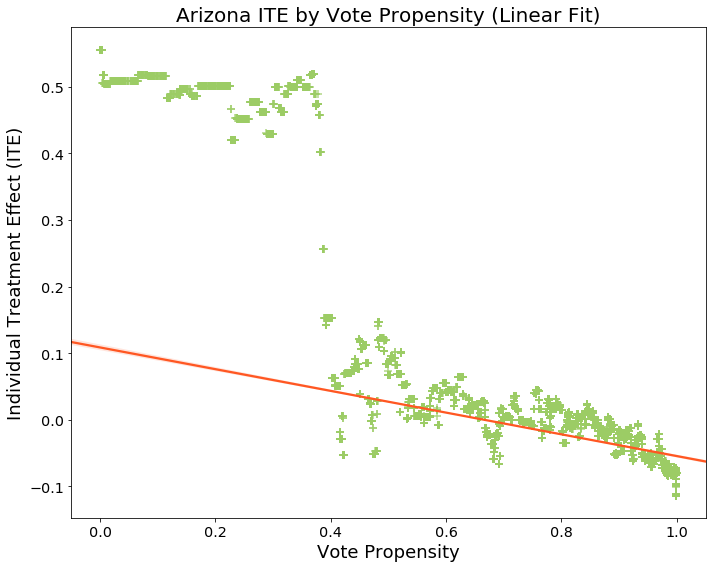

In [58]:
import matplotlib.pylab as pylab
params = {
        'axes.labelsize': '18',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

plt.figure(figsize=(10, 8))
ax = sns.regplot(x='Propensity', y='ITE',
                 data=learner_df, 
                 order=1,
                 ci=100, 
                 marker="+",
                 scatter_kws={'color':'#9CCC65',"s": 50}, 
                 line_kws={'color':'#FF5722'})

plt.xlabel("Vote Propensity")
plt.ylabel("Individual Treatment Effect (ITE)")

plt.title('Arizona ITE by Vote Propensity (Linear Fit)',
          {'fontsize': 20,
        'fontweight' : 5})
plt.tight_layout()
plt.savefig('AZ One with Line', dpi=800)

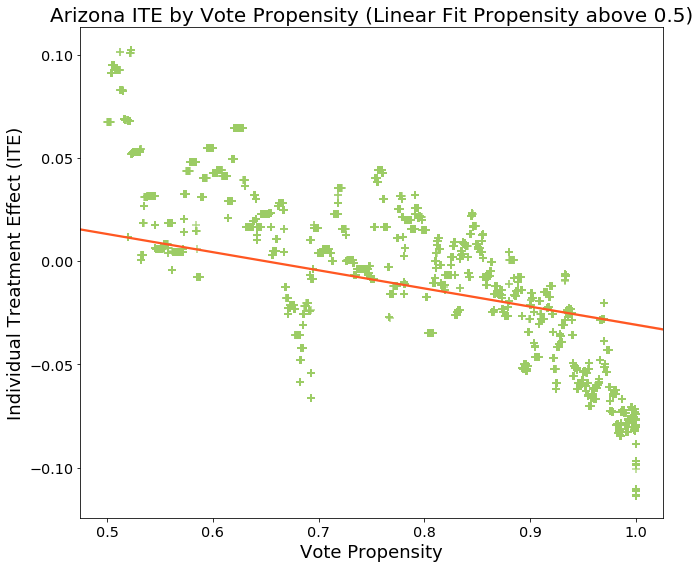

In [59]:
plt.figure(figsize=(10, 8))
ax = sns.regplot(x='Propensity', y='ITE',
                 data=learner_df[learner_df.Propensity>0.5], 
                 order=1,
                 ci=100, 
                 marker="+",
                 scatter_kws={'color':'#9CCC65',"s": 50}, 
                 line_kws={'color':'#FF5722'})

plt.xlabel("Vote Propensity")
plt.ylabel("Individual Treatment Effect (ITE)")

plt.title('Arizona ITE by Vote Propensity (Linear Fit Propensity above 0.5)',
          {'fontsize': 20,
        'fontweight' : 5})
plt.tight_layout()
plt.savefig('AZ One Higher Half with Line', dpi=800)

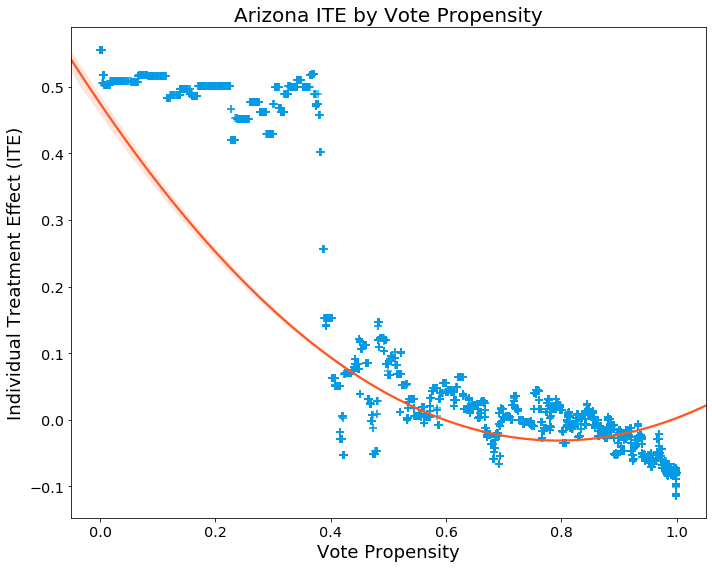

In [60]:
plt.figure(figsize=(10, 8))
ax = sns.regplot(x='Propensity', y='ITE',
                 data=learner_df, 
                 order=2,
                 ci=100, 
                 marker="+",
                 scatter_kws={'color':'#039be5',"s": 50}, 
                 line_kws={'color':'#FF5722'})

plt.xlabel("Vote Propensity")
plt.ylabel("Individual Treatment Effect (ITE)")

plt.title('Arizona ITE by Vote Propensity',
          {'fontsize': 20,
        'fontweight' : 5})
plt.tight_layout()
plt.savefig('AZ One with Parabola', dpi=800)

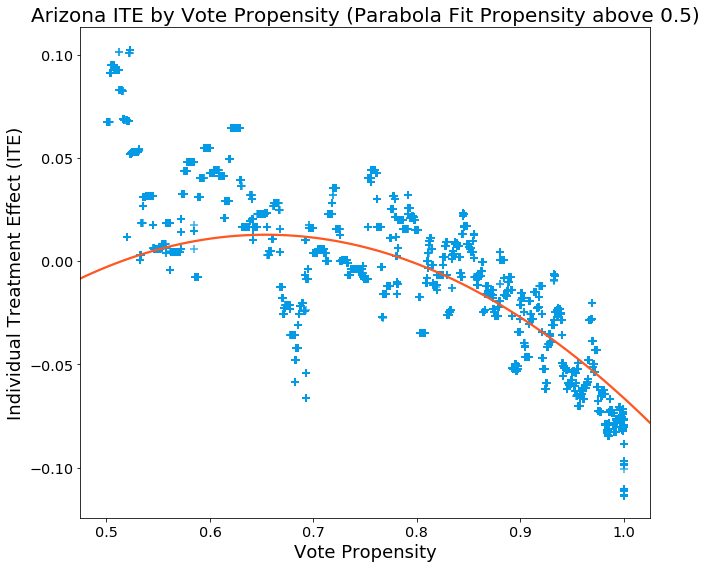

In [61]:
plt.figure(figsize=(10, 8))
ax = sns.regplot(x='Propensity', y='ITE',
                 data=learner_df[learner_df.Propensity>0.5], 
                 order=2,
                 ci=100, 
                 marker="+",
                 scatter_kws={'color':'#039be5',"s": 50}, 
                 line_kws={'color':'#FF5722'})

plt.xlabel("Vote Propensity")
plt.ylabel("Individual Treatment Effect (ITE)")

plt.title('Arizona ITE by Vote Propensity (Parabola Fit Propensity above 0.5)',
          {'fontsize': 20,
        'fontweight' : 5})
plt.tight_layout()
plt.savefig('AZ One Higher Half with Parabola', dpi=800)

In [62]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def sigmoid(x, a, b, c, d):
    # a adjusts amplitude
    # b adjusts y offset
    # c adjusts x offset
    # d adjusts slope
    return ((a - b) / (1. + np.exp(x - (c / 2)) ** d)) + b


xdata = np.array(learner_df.Propensity)
ydata = np.array(learner_df.ITE)


p0 = [max(ydata), min(ydata),max(xdata), 1]

# fit the data
popt, pcov = curve_fit(sigmoid, xdata, ydata, p0)


In [66]:
np.set_printoptions(suppress=True) #prevent numpy exponential 
                                   #notation on print, default False

In [67]:
popt

array([ 0.53030111, -0.00706242,  0.76054555, 22.51102556])

In [63]:
pd.reset_option("all")


: boolean
    use_inf_as_null had been deprecated and will be removed in a future
    version. Use `use_inf_as_na` instead.



In [405]:
pd.DataFrame({'az_sigmoid': popt}).to_csv('../../Machine Learing HTE/1_data/az_one/AZ_one_sigmoid.csv', index=False)

In [80]:
X = learner_df[['Propensity']]
X = sm.add_constant(X)

In [396]:
from sklearn.metrics import mean_squared_error

ols_mse = mean_squared_error(ydata, np.array(ols.predict(X)))
sig_mes = mean_squared_error(ydata, np.array(sigmoid(xdata, *popt)))



'sigmoid fit MSE'

In [71]:
from sklearn.metrics import mean_squared_error

In [84]:
ols_mse = mean_squared_error(ydata, np.array(ols.predict(X)))

In [72]:
ols2_mse = mean_squared_error(ydata, np.array(ols2.predict(X)))

In [75]:
sig_mes = mean_squared_error(ydata, np.array(sigmoid(xdata, *popt)))

In [85]:
'linear fit MSE: {:.6f}'.format(ols_mse)

'linear fit MSE: 0.001593'

In [86]:
'Sigmoid fit MSE: {:.6f}'.format(sig_mes)

'Sigmoid fit MSE: 0.000420'

In [77]:
'Sigmoid fit MSE: {:.6f}'.format(ols2_mse)

'Sigmoid fit MSE: 0.001047'

In [78]:
'Sigmoid fit reduce MSE by {:.2%}'.format(1-sig_mes/ols2_mse)

'Sigmoid fit reduce MSE by 59.87%'

In [87]:
'Sigmoid fit reduce MSE by {:.2%}'.format(1-sig_mes/ols_mse)

'Sigmoid fit reduce MSE by 73.63%'

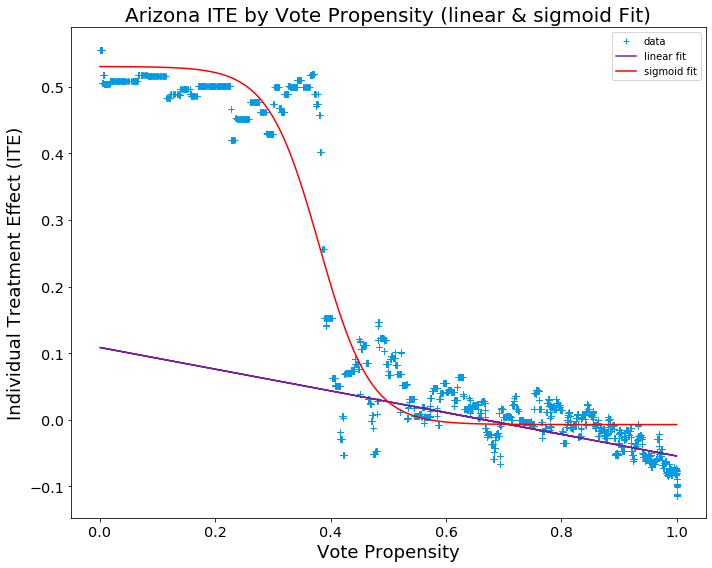

In [64]:
plt.figure(figsize=(10, 8))
# plot data
plt.plot(xdata, ydata, '+',c='#039be5',label='data')

# plot linear fit
plt.plot(xdata, np.array(ols.predict(X)), '-',c='#7b1fa2', label='linear fit')

# plot sigmoid fit
xdata_new = np.linspace(0, 1, 1000)
plt.plot(xdata_new, sigmoid(xdata_new, *popt), 'r-', label='sigmoid fit')


plt.legend(loc='best')
plt.xlabel("Vote Propensity")
plt.ylabel("Individual Treatment Effect (ITE)")

plt.title('Arizona ITE by Vote Propensity (linear & sigmoid Fit)',
          {'fontsize': 20,
        'fontweight' : 5})
plt.tight_layout()
plt.savefig('AZ One with both fit', dpi=800)
plt.show()

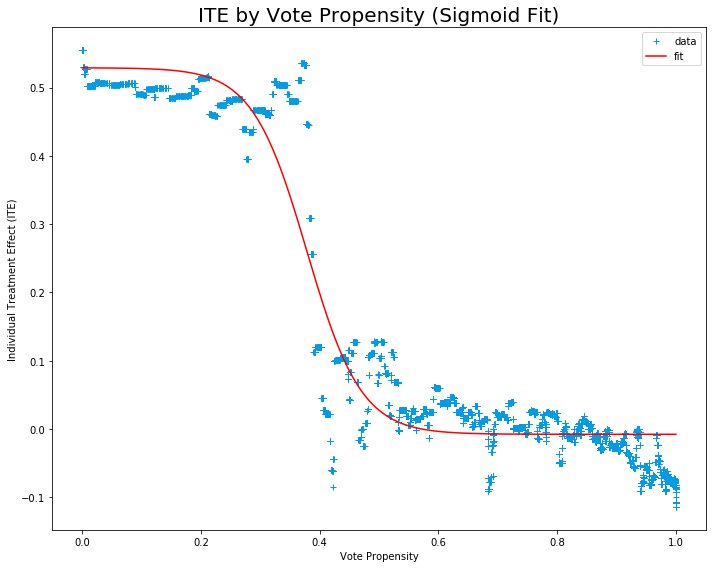

In [375]:
plt.figure(figsize=(10, 8))
# plot data
plt.plot(xdata, ydata, '+',c='#039be5',label='data')

# plot the result
xdata_new = np.linspace(0, 1, 1000)
plt.plot(xdata_new, sigmoid(xdata_new, *popt), 'r-', label='fit')

plt.legend(loc='best')
plt.xlabel("Vote Propensity")
plt.ylabel("Individual Treatment Effect (ITE)")

plt.title('ITE by Vote Propensity (Sigmoid Fit)',
          {'fontsize': 20,
        'fontweight' : 5})
plt.tight_layout()
plt.savefig('AZ One with Sigmoid', dpi=800)
plt.show()

In [391]:
learner_df.head()

,Propensity,ITE,Treatment,Turnout,IPW,hh_id,Propensity_square
0,83.637%,0.914%,1,0,121.977%,24321,69.952%
1,54.941%,0.564%,1,0,121.799%,54491,30.185%
2,65.946%,0.494%,1,0,122.044%,167763,43.489%
3,54.941%,0.564%,1,0,121.977%,233259,30.185%
5,54.941%,0.564%,0,1,121.851%,2300,30.185%


# Simulation

In [3]:
learner_df = pd.read_csv('../../Machine Learing HTE/1_data/az_one/AZ_one_with_ITEs.csv')

In [4]:
learner_df.Treatment.value_counts()

1    185885
0     41113
Name: Treatment, dtype: int64

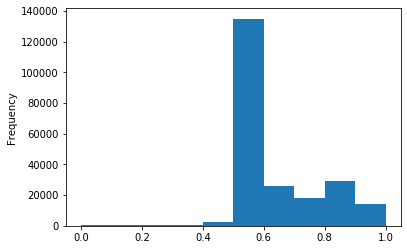

In [5]:


sim = learner_df.sort_values('Propensity',ascending=True).reset_index(drop=True)

sim.Treatment.value_counts()

sim.Propensity.plot('hist')

In [6]:
sim.tail()

,Propensity,ITE,Treatment,Turnout,hh_id,Propensity_square,Propensity Range
226993,1.0,-0.079373,1,1,143051,1.0,"(0.9, 1.0]"
226994,1.0,-0.079373,1,1,130827,1.0,"(0.9, 1.0]"
226995,1.0,-0.079373,1,1,10810,1.0,"(0.9, 1.0]"
226996,1.0,-0.079373,1,1,95115,1.0,"(0.9, 1.0]"
226997,1.0,-0.079373,1,1,222331,1.0,"(0.9, 1.0]"


In [7]:
sim.loc[0: 185885,'sim_treat'] = 1

sim.loc[185885:,'sim_treat'] = 0

In [8]:
# display and export regression table
from stargazer.stargazer import Stargazer
from IPython.core.display import HTML
from IPython.display import Latex

In [9]:



X = sim[['sim_treat']]

X = sm.add_constant(X)

y = sim['ITE']

sm_az = sm.OLS(y, X).fit(cov_type='cluster', cov_kwds={'groups': sim['hh_id']})

X = sim[['Treatment']]

X = sm.add_constant(X)

y = sim['ITE']


ite_il = sm.OLS(y, X).fit(cov_type='cluster', cov_kwds={'groups': sim['hh_id']})

stargazer = Stargazer([ite_il,sm_az])
stargazer.significant_digits(4)
stargazer.title('ITE vs Simulation (Arizona One)')
stargazer.covariate_order(['const',  'Treatment','sim_treat'])

stargazer.rename_covariates({'const': 'Intercept',
                            'sim_treat': 'Optimized Alloaction'})


stargazer.custom_columns(['Treatment Assignment', 'Optimized'], [1,1])
HTML(stargazer.render_html())

In [10]:
Latex(stargazer.render_latex())

<IPython.core.display.Latex object>